In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline



In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#export 
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
from torch import optim
from torch.autograd import Variable
from sklearn import metrics
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as data
import PIL
from scipy.ndimage import rotate, map_coordinates, gaussian_filter, zoom
from scipy.optimize import curve_fit
from torchvision import transforms
#from functools import partial
import functools
import math
import random
import torchvision.transforms.functional as F1
import warnings
from PIL import Image
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
import nibabel as nib
from scipy import stats
from scipy.signal import argrelmax
import statsmodels.api as sm

import apex.fp16_utils as fp16



In [4]:
from torch.nn.utils import parameters_to_vector


In [5]:
from fastai.vision import *
from fastai.metrics import error_rate

In [6]:
path_images = Path('/home/jupyter/data/radc_segmentation/liquid_seg1/')
path_masks =  Path('/home/jupyter/data/radc_segmentation/liquid_seg1/')

In [7]:
path_images.ls()

[PosixPath('/home/jupyter/data/radc_segmentation/liquid_seg1/100520_50108048'),
 PosixPath('/home/jupyter/data/radc_segmentation/liquid_seg1/valid'),
 PosixPath('/home/jupyter/data/radc_segmentation/liquid_seg1/100708_20331760'),
 PosixPath('/home/jupyter/data/radc_segmentation/liquid_seg1/train'),
 PosixPath('/home/jupyter/data/radc_segmentation/liquid_seg1/100622_11469504')]

In [8]:
def smooth_hist(data):
    
    """
    use KDE to get smooth estimate of histogram
    Args:
        data (np.ndarray): array of image data
    Returns:
        grid (np.ndarray): domain of the pdf
        pdf (np.ndarray): kernel density estimate of the pdf of data
    """
    data = data.flatten().astype(np.float64)
    bw = data.max() / 80

    kde = sm.nonparametric.KDEUnivariate(data)

    kde.fit(kernel='gau', bw=bw, gridsize=80, fft=True)
    pdf = 100.0 * kde.density
    grid = kde.support
   
    return grid, pdf

In [9]:
def get_largest_mode(data):
    """
    gets the last (reliable) peak in the histogram
    Args:
        data (np.ndarray): image data
    Returns:
        largest_peak (int): index of the largest peak
    """
    grid, pdf = smooth_hist(data)
    largest_peak = grid[np.argmax(pdf)]
    return largest_peak


In [10]:
def get_last_mode(data, rare_prop=96, remove_tail=True):
    """
    gets the last (reliable) peak in the histogram
    Args:
        data (np.ndarray): image data
        rare_prop (float): if remove_tail, use the proportion of hist above
        remove_tail (bool): remove rare portions of histogram
            (included to replicate the default behavior in the R version)
    Returns:
        last_peak (int): index of the last peak
    """
    if remove_tail:
        rare_thresh = np.percentile(data, rare_prop)
        which_rare = data >= rare_thresh
        data = data[which_rare != 1]
    grid, pdf = smooth_hist(data)
    maxima = argrelmax(pdf)[0]  # for some reason argrelmax returns a tuple, so [0] extracts value
    last_peak = grid[maxima[-1]]
    return last_peak

In [11]:
#path_images_modeNorm = Path('/home/jupyter/data/radc_segmentation/mode_normalized/')

In [12]:
#f'{path_images}c'

(288, 288, 42)
2203.100940782442 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100527_50405330 122.3207 88.33234
(288, 288, 42)
1616.4543232715037 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100520_89377194 118.46905 89.470055
(288, 288, 42)
40271.610371170646 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100331_20594407 118.52183 94.10446
(288, 288, 42)
64664.76791646161 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100727_10473384 101.763504 90.50809
(288, 288, 42)
1788.0204505740187 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100330_21406920 136.11493 89.15971
(288, 288, 42)
1759.298425641398 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100610_68725248 128.67172 89.79695
(288, 288, 42)
1763.4023373220848 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100316_21362537 131.86073 88.04019
(288, 288, 42)
1948.5198760986327 /home/jupyter/data/radc_segmentation/liquid_seg1/train/100610_50108598 127.020164 89.80539
(288, 288

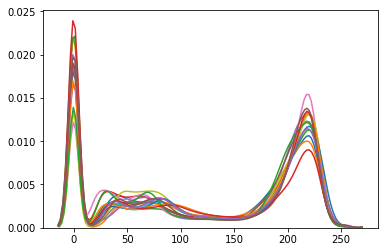

In [13]:
MEAN = 0.00
STD  = 0.00
cntr = 0.00
for each_file in Path(f'{path_images}/train').ls():
    
    echo_0_data_f = nib.load(f'{str(each_file)}/echo.nii.gz')
    echo_0_data = echo_0_data_f.get_data()
    affine  = echo_0_data_f.affine
    
    liquid_peak = get_last_mode(echo_0_data)
    echo_0_data_f  = (echo_0_data/liquid_peak) *220 #bring liquid peak at 220 for all subjects 
    echo_0_data_f[echo_0_data_f >= 255] =255.00 #everything greater than 255 is 255
    
    #mask = nib.load(f'{str(each_file)}/mask.nii.gz').get_data()
    #mask[echo_0_data_f <15 ] =2.00    #this is temporary...everything that is not tissue or liquid is vaccume
                                      # ideally we will like to create high quality training data
    #img = nib.Nifti1Image(mask, affine)
    #nib.save(img,f'{str(each_file)}/mask1.nii.gz' ) 
    
    print(echo_0_data_f.shape)
    sns.distplot(echo_0_data_f.flatten(), hist=False);
    MEAN+=echo_0_data_f.mean()
    STD+=echo_0_data_f.std()
    cntr +=1
    print (liquid_peak,each_file,echo_0_data_f.mean(), echo_0_data_f.std())




1831.6683206753469 /home/jupyter/data/radc_segmentation/liquid_seg1/valid/100331_16513683 134.70667 88.73663
1712.8171902033287 /home/jupyter/data/radc_segmentation/liquid_seg1/valid/100330_37065652 121.917625 91.72429
1462.2350311880039 /home/jupyter/data/radc_segmentation/liquid_seg1/valid/100330_51400993 132.12209 90.403564
1714.1742399440975 /home/jupyter/data/radc_segmentation/liquid_seg1/valid/100420_20939834 124.89481 90.95168


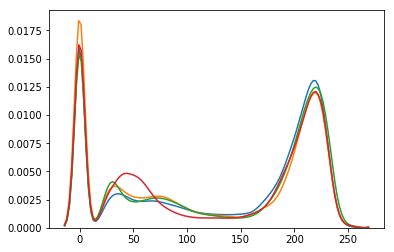

In [14]:
#repeat procedure for validation data but dont change mean and variance
for each_file in Path(f'{path_images}/valid').ls():
    
    echo_0_data_f = nib.load(f'{str(each_file)}/echo.nii.gz')
    echo_0_data = echo_0_data_f.get_data()
    affine  = echo_0_data_f.affine
    
    liquid_peak = get_last_mode(echo_0_data)
    echo_0_data_f  = (echo_0_data/liquid_peak) *220
    echo_0_data_f[echo_0_data_f >= 255] =255.00
    
    #mask = nib.load(f'{str(each_file)}/mask.nii.gz').get_data()
    #mask[echo_0_data_f <15 ] =2.00
    #img = nib.Nifti1Image(mask, affine)
    #nib.save(img,f'{str(each_file)}/mask1.nii.gz' )
   
    sns.distplot(echo_0_data_f.flatten(), hist=False); 
    print (liquid_peak,each_file,echo_0_data_f.mean(), echo_0_data_f.std())



In [15]:
MEAN=MEAN/cntr
STD = STD/cntr

In [16]:
MEAN,STD


(125.21439933776855, 89.79304027557373)

In [17]:
echo_0_data_f.shape,echo_0_data_f.mean(), echo_0_data_f.std()

((288, 288, 42), 124.89481, 90.95168)

In [18]:
((echo_0_data_f - MEAN) /STD).mean(), ((echo_0_data_f - MEAN) /STD).std()


(-0.0035593642, 1.0129038)

In [19]:
def show_subject_numpy(xs):
    
    totalImages = xs.shape[0]
    totalImagesCols = 4
    totalImagesRows =totalImages//totalImagesCols     
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows))
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        disp = xs[imgIndex,...]
        ax.imshow(disp)
    plt.tight_layout()

In [20]:
echo_0_data_f1 = echo_0_data_f.swapaxes(0,2)
echo_0_data_f2 = np.stack((echo_0_data_f1,)*3, axis=3)
print(echo_0_data_f2.shape)
show_subject_numpy(echo_0_data_f1)

(42, 288, 288, 3)


In [21]:
#def get_data(pathDir,pathMask):
#    dataPath,maskPath=[],[]
#    for each_file,each_mask in zip(pathDir.ls(),pathMask.ls()):
#        dataPath.append(each_file)
#        maskPath.append(each_mask)
#    dataPath.sort()
#    maskPath.sort()
#    return dataPath,maskPath


In [22]:
def get_data(pathDir):
    dataPath,maskPath=[],[]
    for each_subject in (pathDir.ls()):
        dataPath.append(f'{each_subject}/echo.nii.gz')
        maskPath.append(f'{each_subject}/mask3.nii.gz')
    return dataPath,maskPath



In [23]:
p,m = get_data(Path(f'{path_images}/train'))

In [24]:
p[:2]

['/home/jupyter/data/radc_segmentation/liquid_seg1/train/100527_50405330/echo.nii.gz',
 '/home/jupyter/data/radc_segmentation/liquid_seg1/train/100520_89377194/echo.nii.gz']

In [25]:
m[:2]

['/home/jupyter/data/radc_segmentation/liquid_seg1/train/100527_50405330/mask3.nii.gz',
 '/home/jupyter/data/radc_segmentation/liquid_seg1/train/100520_89377194/mask3.nii.gz']

In [26]:
#This cell is just testing shapes of tensors...Can be excluded

labels_org = nib.load(str(m[0])).get_data()
print(labels_org.shape)
labels_org=labels_org.swapaxes(0,2).astype(np.int)
print(labels_org.shape)
print(np.max(labels_org))
       
labels = (np.zeros((int(np.max(labels_org)+1),labels_org.shape[0],labels_org.shape[1],labels_org.shape[2] )))
  
print (labels.shape, labels_org.shape)

for idx in range(int(np.max(labels_org)+1)):
    print (idx)
    temp = labels[idx,...]
    temp [labels_org==idx] =1
    labels[idx,...]= temp

labels=labels.swapaxes(0,1).astype(np.int)
print(labels.shape)

(288, 288, 42)
(42, 288, 288)
3
(4, 42, 288, 288) (42, 288, 288)
0
1
2
3
(42, 4, 288, 288)


In [27]:
#export
# All transforms for data augmentation

#Resize data 
class ResizeVol: 
    def __init__(self, size,  **kwargs): 
        assert isinstance(size, int) or (isinstance(size, Iterable) and len(size) == 2) 
        self.size = size 
        self.interpolationImage = PIL.Image.BILINEAR
        self.interpolationMask = PIL.Image.NEAREST

    def __call__(self,i, m):
        images = [F1.resize(i[c], self.size, self.interpolationImage ) for c in range(len(i))]
        mask = [F1.resize(m[c], self.size, self.interpolationMask ) for c in range(len(m))]
        return images,mask

#Randonly flip data horizontally
class RandomFlipVol: 
    def __init__(self, p=0.5): self.p = p
        
    def __call__(self, i, m):
        if random.random() < self.p:
            i = [F1.hflip(i[c]) for c in range(len(i))]
            m = [F1.hflip(m[c]) for c in range(len(m))]
        return i,m

#Randomly rotate, translate and scale data withing range    
class RandomAffineVol: 
    def __init__(self, degrees=0, translate=None, scale=None, shear=None, resample=False, fillcolor=0): 
        self.degrees = degrees 
        self.translate = translate 
        self.scale = 1.
        self.shear= .0 
        self.resample = resample 
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(degrees,translate, img_size,scale_range ):

        angle = random.uniform(degrees[0], degrees[1])
        max_dx = translate[0] * img_size[0]
        max_dy = translate[1] * img_size[1]
        translations = (np.round(random.uniform(-max_dx, max_dx)),np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(scale[0], scale[1])
        shear = 0.0
        fillcolor = 0
        return angle,translations,scale,shear

    def __call__(self, i,m,params):

        #ret = self.get_params(self.degrees,self.translate,[m[0].size[-1],m[0].size[-2]]) 
        trfmImages = [F1.affine(i[c], *params,PIL.Image.BILINEAR,0) for c in range(len(i))]
        trfmMasks =  [F1.affine(m[c], *params,PIL.Image.NEAREST,0) for c in range(len(m))]
        
        return trfmImages,trfmMasks



#Normalize to zero mean and on std dev.
class Normalize(object):
    def __init__(self,MEAN,STD,  **kwargs):
        self.MEAN, self.STD = MEAN, STD
        
    def __call__(self,i,m):
        i = (i - self.MEAN) / self.STD
        m = m
        return  i,m
    

#Convert numpy arrays to PIL (python imaging library). 
class ToPIL(object):
    def __init__(self,  **kwargs):
        self.modeImage = 3
        self.modeMask  = 1
        
    def __call__(self,i,m):  
        toPIL = transforms.ToPILImage() 
        
        PILslices = [toPIL(i[c]) for c in np.arange(i.shape[0])]    
        PILmasks  = [toPIL(m[c]) for c in np.arange(m.shape[0])]
       
        return PILslices,PILmasks

#Convert PIL to pytorch tensors  
class ToTensor(object):
   
    def __call__(self, i,m):  
        toTensor = transforms.ToTensor()
        TensorListImage = [toTensor(i[c].convert('RGB') )for c in range(len(i))]
        TensorListMask = [toTensor(m[c].convert('L'))for c in range(len(m))]
        iT = torch.stack(TensorListImage)
        mT = (torch.stack(TensorListMask)*255).long()
        return iT,mT

In [28]:
#export
class Dataset(data.Dataset):
    def __init__(self,pathDir,pathMask,transform=None):
        super().__init__()
        self.paths,self.labels = get_data(pathDir)
        self.transform = transform
        
    def __getitem__(self,index):
        path_images = self.paths[index]
        path_masks = self.labels[index]
        
        vol = nib.load(str(path_images)).get_data()
        
        liquid_peak = get_last_mode(vol)
        vol  = (vol/liquid_peak) *220
        vol[vol >= 255] =255.00 
        
        vol=vol.swapaxes(0,2)
        vol= np.uint8(vol)
        
        
        labels= nib.load(str(path_masks)).get_data()
        labels=labels.swapaxes(0,2)
        labels= np.uint8(labels)
        
        vol= vol[0:40,:,:]
        labels = labels[0:40,:,:]
        # convert to RGB
        vol_rgb = np.stack((vol,)*3, axis=3) #create place holder for 3 RGB channels
       
        # adding adjacent slices in place of channels. This needs to be tested if it improves accuracy.
        #for sl_idx in range(1,vol.shape[0]-1):
        #    vol_rgb[sl_idx,:,:,0] = vol[sl_idx-1,:,:]
        #    vol_rgb[sl_idx,:,:,2] = vol[sl_idx+1,:,:]
        
        
        # transforms 
        ToPILv = ToPIL()
        volPIL,lablelsPIL = ToPILv(vol_rgb,labels)
        
        ResizeVolv = ResizeVol(288)
        volPIL,lablelsPIL = ResizeVolv(volPIL,lablelsPIL)
        if(self.transform): # apply transforms only on training data but not on validation data
            
            RandomFlipVolv = RandomFlipVol(0.5)
            volPIL,lablelsPIL  = RandomFlipVolv( volPIL,lablelsPIL )
            
            RandomAffineVolv = RandomAffineVol()
            params = RandomAffineVolv.get_params((-15,15),(0.15,0.15),[volPIL[0].size[-1],volPIL[0].size[-2]],(1.0,1.05))
            print(params)
            volPIL,lablelsPIL = RandomAffineVolv(volPIL,lablelsPIL,params)
        
        ToTensorv = ToTensor()
        vol_tensor, label_tensor = ToTensorv(volPIL,lablelsPIL)
        Norm = Normalize(MEAN/255.0,STD/255.0)
        vol_tensor, label_tensor = Norm(vol_tensor,label_tensor)
        
        
        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)
    
    

In [29]:
train_dataset = Dataset(Path(f'{path_images}/train'),True)
valid_dataset = Dataset(Path(f'{path_images}/valid'),None)




In [30]:
train_dataset.paths[0], train_dataset.labels[0]

('/home/jupyter/data/radc_segmentation/liquid_seg1/train/100527_50405330/echo.nii.gz',
 '/home/jupyter/data/radc_segmentation/liquid_seg1/train/100527_50405330/mask3.nii.gz')

In [31]:
#export
def get_dls(train_ds,valid_ds, bs=1, **kwargs):
    return (data.DataLoader(train_ds, batch_size=bs, num_workers=8,shuffle=True, **kwargs),
            data.DataLoader(valid_ds, batch_size=bs, num_workers=8,shuffle=False, **kwargs))



In [32]:
train_dl, valid_dl= get_dls(train_dataset,valid_dataset,bs=1)

In [33]:
#export
def show_batch(dl):
    xs,ys = next(iter(dl))
    
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    xs = xs.squeeze(0)
    ys = ys.squeeze().float()
    #print(xs.shape,ys.shape)
    totalImages = xs.shape[0]
    totalImagesCols = 4
    totalImagesRows =totalImages//totalImagesCols     
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows))
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        disp = xs[imgIndex,...]
        disp = disp.permute(1,2,0).numpy()
        disp = disp[:,:,1] # just display central slice
        disp = np.stack((disp,)*3, axis=2) ## copy central slice to 3RGB channels for display purpose 
        ax.imshow(disp)
        disp_mask = ys[imgIndex,:,:]
        #disp_mask = disp_mask.permute(1,2,0).numpy()
        #print(disp.shape, disp_mask.shape)
        ax.imshow(disp_mask,alpha = 0.5)
    plt.tight_layout()

In [34]:
xs,ys = next(iter(train_dl))

In [35]:
xs.shape, ys.shape

(torch.Size([1, 40, 3, 288, 288]), torch.Size([1, 40, 1, 288, 288]))

In [36]:
ys

tensor([[[[[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2]]],


         [[[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2]]],


         [[[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2]]],


         ...,


         [[[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2]]],


         [[[2, 2

In [37]:
xs[0,10,0,...].mean(), xs[0,10,0,...].std()

(tensor(0.2840), tensor(0.9614))

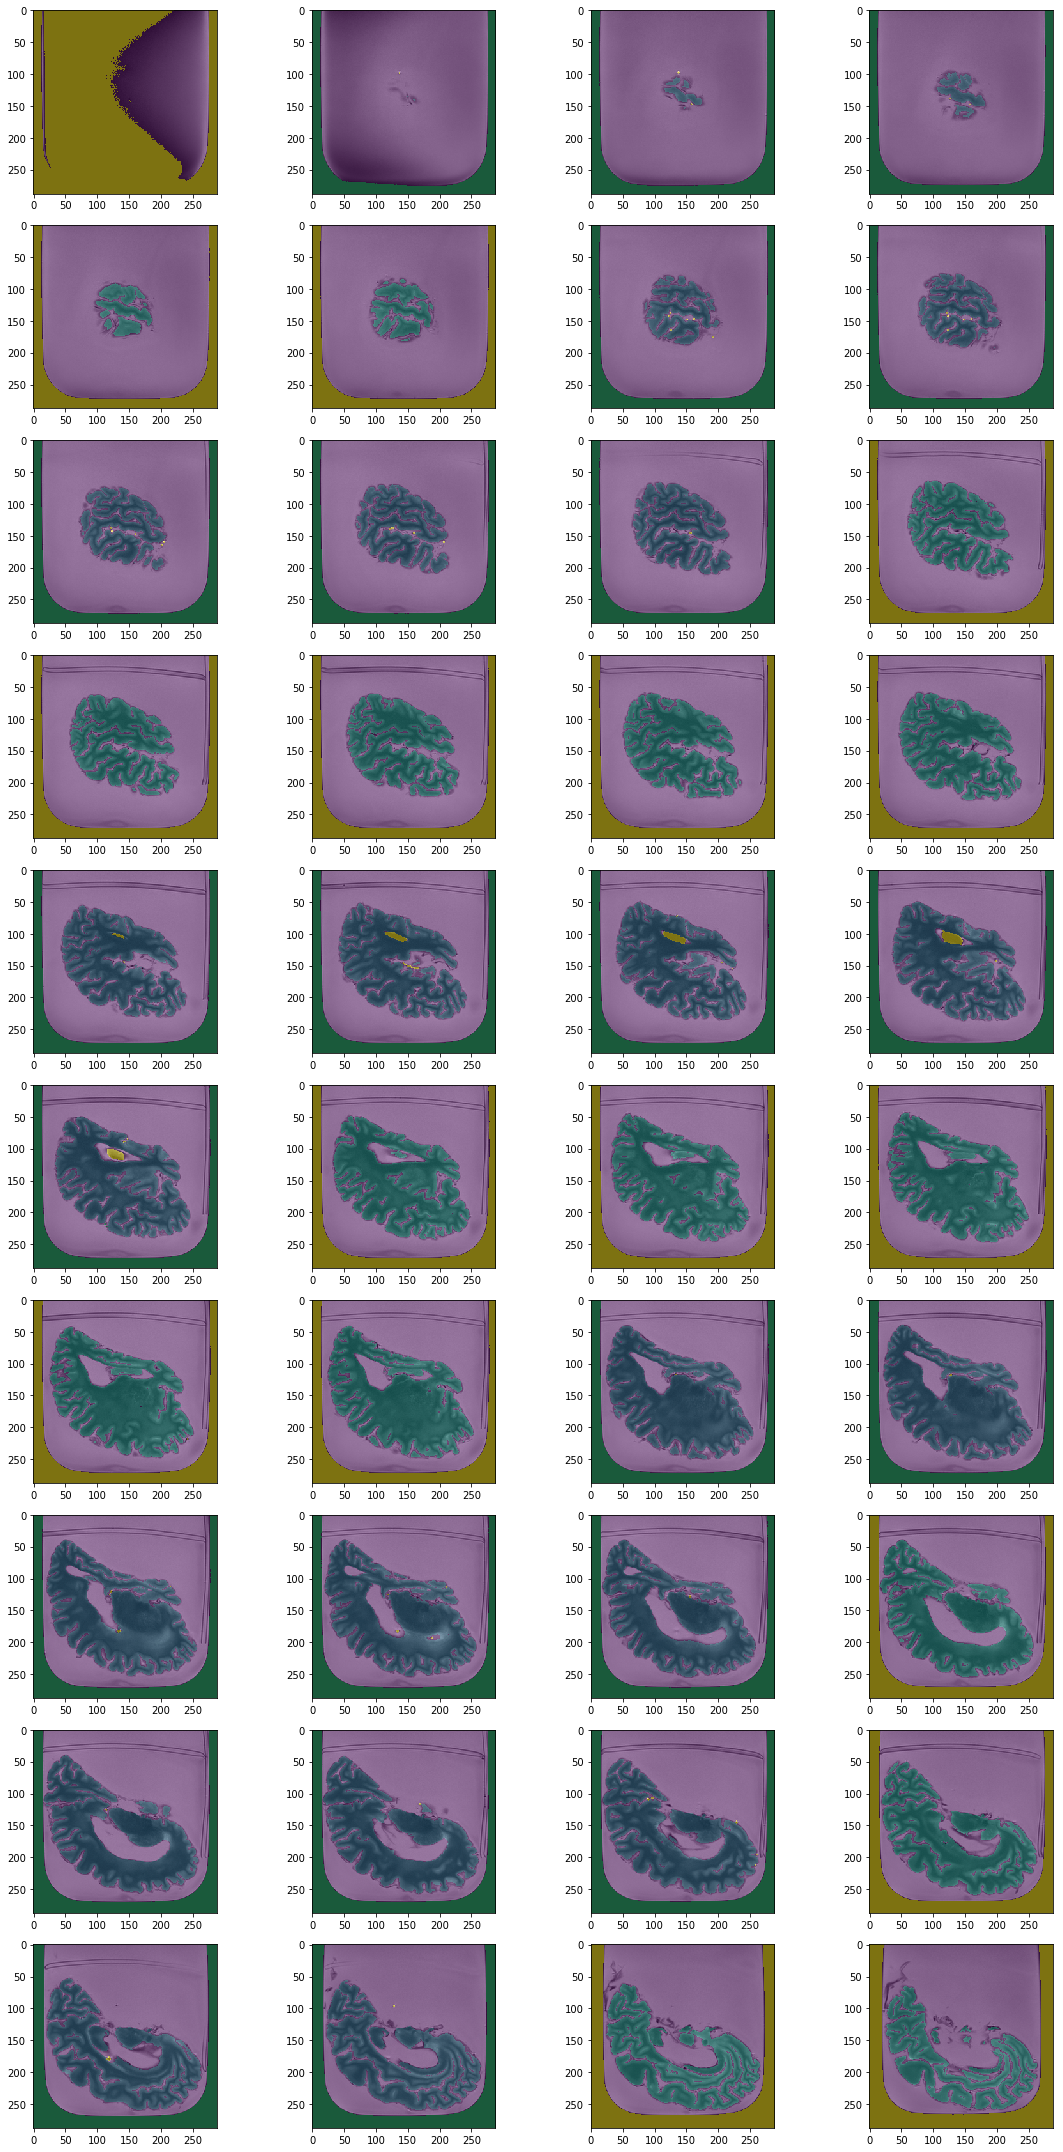

In [38]:
show_batch(valid_dl)

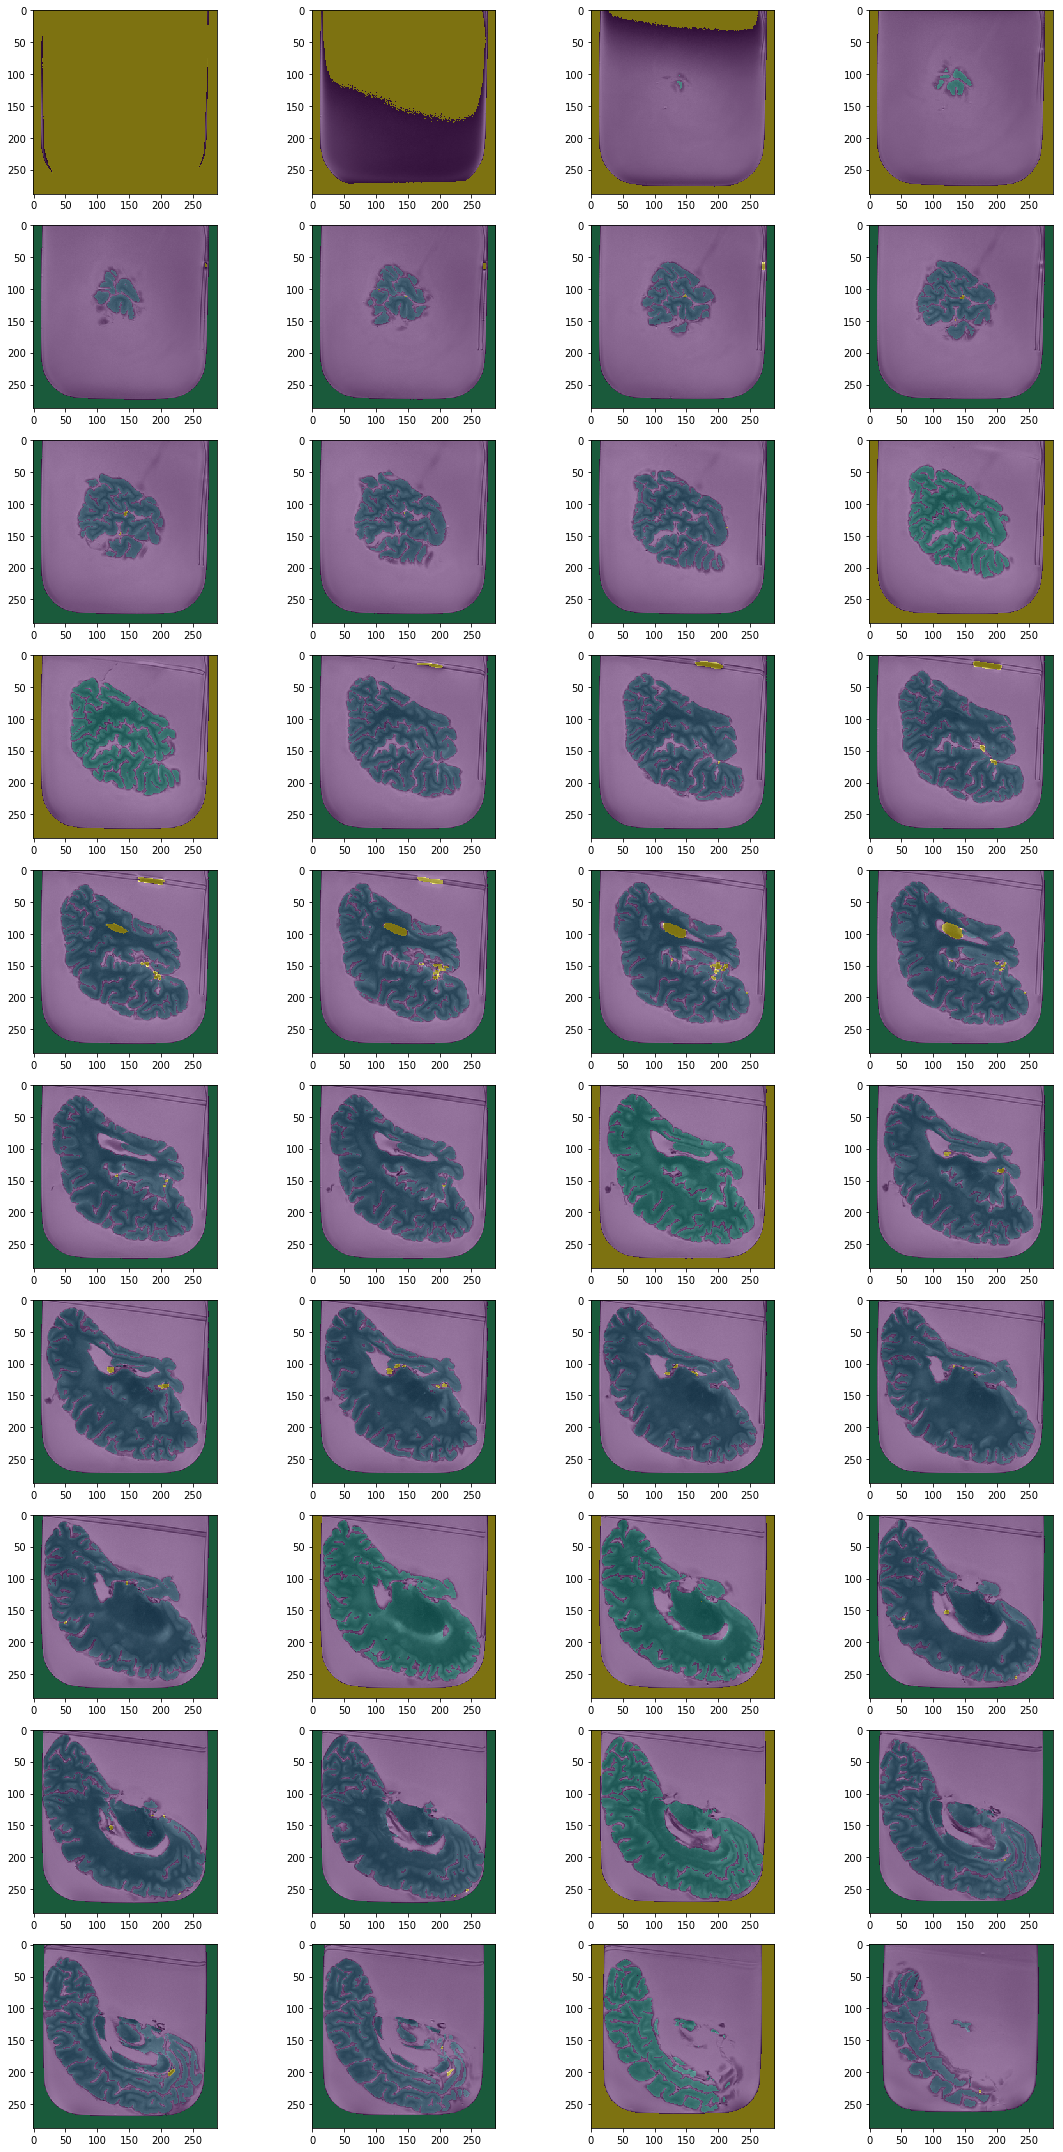

In [39]:
show_batch(train_dl)

In [40]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl):
        self.train_dl, self.valid_dl = train_dl,valid_dl
     
    @property
    def train_ds(self): return self.train_dl.dataset
    
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
   

In [41]:
Data = DataBunch(*get_dls(train_dataset,valid_dataset, bs=1))

In [42]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass


In [43]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

In [44]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

#export
def sgd_step(p, lr, **kwargs):
    
    p.data.add_(-lr, p.grad.data)
    return p

sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

opt_func=partial(sgd_opt, wd=0.001)

In [45]:
#export
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [46]:
class StdDownsample3D(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv1 = nn.Conv3d(nin, nout, (3,1,1), stride=1,padding=(1,0,0))
        self.conv2 = nn.Conv3d(nout*2, nout, (3,1,1), stride=1,padding=(1,0,0))
        self.bn1 = nn.BatchNorm3d(nout)
        self.bn2 = nn.BatchNorm3d(nout)
        
    def forward(self, x): 
        x =  self.bn1(F.relu(self.conv1(x)))
        #x =  self.bn2(F.relu(self.conv2(x)))
        
        return x 

simple_down3d  = nn.Sequential(StdDownsample3D(3,3)) # we want 3 channels in 3 channels out, stride =1 and padding=1
                                                     # so we can introduce some smoothing but keep shape of tensors same


In [47]:
class SaveFeatures():
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, 
                                          stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    

class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 4, 2, stride=2)
        
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [48]:
#export
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        pretrainedModel = models.resnet34(pretrained=True)
        self.simple_down = nn.Sequential(*list(pretrainedModel.children())[:-2]) 
        self.simple_up = Unet34(self.simple_down)
        #self.firstDown3D = simple_down3d
       
        
    def forward(self, x):
        
        #x = x.permute(0,2,1,3,4)  
        #x = self.firstDown3D(x)
        #x = x.permute(0,2,1,3,4)
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.simple_up(x)    
        x = x[None,...]
        return x 
        
       

In [49]:
#export
#def get_model(data, lr=1e-4):
#    model = MRNet()
#    return model, optim.Adam(model.parameters(),lr)

#class Learner():
#    def __init__(self, model, opt, loss_func, data):
#        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [50]:
#export
#def create_learner(model_func, loss_func, data):
#    return Learner(*model_func(data), loss_func, data)




In [51]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [52]:
# Somewhat more flexible way
device = torch.device('cuda',0)

# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

#export
#class CudaCallback(Callback):
#    def begin_fit(self): self.model.cuda()
#    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()   
class CudaCallback(Callback):
    def __init__(self): 
        device = torch.device('cuda',0)
        self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)        




In [53]:
def acc_camvid(input, target,void_code=2):
    preds_f = torch.max(input,2,keepdim=True).indices
    #mask = (target==1)
    #return (preds_f[mask==1]==target[mask==1]).float().mean()
    return (preds_f==target).float().mean()

In [54]:
loss_func = nn.CrossEntropyLoss()

def flatten_loss_crossEntroy(input,target):
    
    input = input.squeeze(0)
    target = target.squeeze(0)
    
    input = input.transpose(-1,-1).contiguous()
    target = target.transpose(-1,-1).contiguous()
    input = input.permute(0,2,3,1).contiguous()
    input = input.view(input.shape[0]*input.shape[1]*input.shape[2],input.shape[3])
    target = target.view(-1)
    return loss_func(input, target)

In [55]:
#export
def get_learner( data, lr=0.4,  loss_func=flatten_loss_crossEntroy,
                cbs =None, cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = MRNet()    
    return Learner(model, data, loss_func=loss_func, cb_funcs= cb_funcs,  opt_func=opt_func )

In [56]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])


In [57]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
        
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [58]:
cbfs = [CudaCallback,LR_Find,Recorder]

In [59]:
learn = get_learner(Data, 0.4, cb_funcs=cbfs, opt_func=opt_func)


In [ ]:
%time learn.fit(10)

In [ ]:
learn.recorder.plot()



In [ ]:
learn.recorder.plot_lr()



In [60]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.4, 0.6), sched_cos(0.6, 0.1)])

In [61]:
cbfs = [partial(AvgStatsCallback,acc_camvid),
        CudaCallback,Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [62]:
learn = get_learner(Data, 0.4, cb_funcs=cbfs, opt_func=opt_func)




In [63]:
%time learn.fit(10)

train: [0.4330690801143646, tensor(0.8437, device='cuda:0')]
valid: [0.48229432106018066, tensor(0.8308, device='cuda:0')]
train: [0.10896962881088257, tensor(0.9650, device='cuda:0')]
valid: [0.184341162443161, tensor(0.9498, device='cuda:0')]
train: [0.07628926634788513, tensor(0.9760, device='cuda:0')]
valid: [0.07875675708055496, tensor(0.9764, device='cuda:0')]
train: [0.06325691193342209, tensor(0.9796, device='cuda:0')]
valid: [0.0576322078704834, tensor(0.9810, device='cuda:0')]
train: [0.05763295665383339, tensor(0.9808, device='cuda:0')]
valid: [0.045698970556259155, tensor(0.9842, device='cuda:0')]
train: [0.05320151150226593, tensor(0.9819, device='cuda:0')]
valid: [0.047339387238025665, tensor(0.9832, device='cuda:0')]
train: [0.050421059131622314, tensor(0.9827, device='cuda:0')]
valid: [0.042757268995046616, tensor(0.9849, device='cuda:0')]
train: [0.04817623272538185, tensor(0.9835, device='cuda:0')]
valid: [0.04186765104532242, tensor(0.9850, device='cuda:0')]
train: [

In [65]:
learn.recorder.plot_lr()

In [67]:
learn.recorder.plot_loss()

In [70]:
%time learn.fit(10)

train: [0.046173855662345886, tensor(0.9839, device='cuda:0')]
valid: [0.040700990706682205, tensor(0.9853, device='cuda:0')]
train: [0.04496174678206444, tensor(0.9843, device='cuda:0')]
valid: [0.038766756653785706, tensor(0.9857, device='cuda:0')]
train: [0.04352749511599541, tensor(0.9846, device='cuda:0')]
valid: [0.038891151547431946, tensor(0.9859, device='cuda:0')]
train: [0.0407855249941349, tensor(0.9856, device='cuda:0')]
valid: [0.04042133688926697, tensor(0.9851, device='cuda:0')]
train: [0.04084299877285957, tensor(0.9855, device='cuda:0')]
valid: [0.03609228879213333, tensor(0.9867, device='cuda:0')]
train: [0.039042528718709946, tensor(0.9861, device='cuda:0')]
valid: [0.0363665446639061, tensor(0.9865, device='cuda:0')]
train: [0.03849337249994278, tensor(0.9864, device='cuda:0')]
valid: [0.03532993048429489, tensor(0.9869, device='cuda:0')]
train: [0.03746332973241806, tensor(0.9867, device='cuda:0')]
valid: [0.03582613542675972, tensor(0.9867, device='cuda:0')]
train

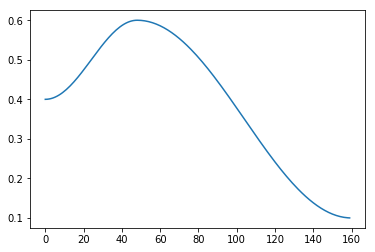

In [72]:
learn.recorder.plot_lr()

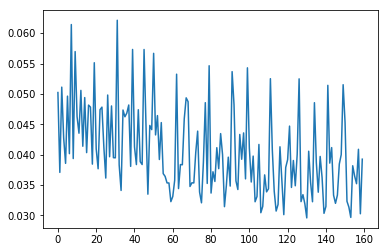

In [73]:
learn.recorder.plot_loss()

In [76]:
%time learn.fit(5)

train: [0.037028927356004715, tensor(0.9869, device='cuda:0')]
valid: [0.041906293481588364, tensor(0.9845, device='cuda:0')]
train: [0.03812599927186966, tensor(0.9862, device='cuda:0')]
valid: [0.03421539068222046, tensor(0.9872, device='cuda:0')]
train: [0.03640265390276909, tensor(0.9870, device='cuda:0')]
valid: [0.034623585641384125, tensor(0.9872, device='cuda:0')]
train: [0.03485957160592079, tensor(0.9876, device='cuda:0')]
valid: [0.034149106591939926, tensor(0.9874, device='cuda:0')]
train: [0.034705039113759995, tensor(0.9877, device='cuda:0')]
valid: [0.03467383235692978, tensor(0.9871, device='cuda:0')]
CPU times: user 1min 22s, sys: 49.5 s, total: 2min 12s
Wall time: 1min 35s


In [78]:
learn.recorder.plot_loss()

In [79]:
xs,ys = next(iter(train_dl))

In [80]:
device = torch.device('cuda',0)

In [81]:

def get_valid_results (show_idx = 6):
    cntr = 0
    for xb,yb in Data.valid_dl:
        #xb,yb = next(iter(Data.valid_dl))
        cntr+=1
        if (cntr == show_idx):
            xb1 = xb.to(device)
            yb1 = yb.to(device)
            with torch.no_grad():
                preds = learn.model(xb1)
    return (xb1,yb1,preds)
    

In [82]:
x,y,p = get_valid_results(2)


In [83]:
#export
def show_result(xs,ys,preds):
    print ("Original Segmantation")
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    xs = xs.squeeze(0)
    
    ys = ys.squeeze()
    totalImages = xs.shape[0]
    totalImagesCols = 4
    totalImagesRows =totalImages//totalImagesCols     
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows))
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        disp = xs[imgIndex,...]
        disp = disp.permute(1,2,0).cpu().numpy()
        disp = disp[:,:,1] # just display central slice
        disp = np.stack((disp,)*3, axis=2) ## copy central slice to 3RGB channels for display purpose 
        ax.imshow(disp)
        ax.imshow(ys[imgIndex,:,:].cpu(),alpha = 0.5)
        #print(ys[imgIndex,:,:].sum())
    plt.tight_layout()
    
    #preds = (torch.sigmoid(preds) > 0.5 ).float()
    #
    print ("Predictions")

    preds = torch.max(preds,2,keepdim=True).indices
    preds = preds.squeeze()

    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows))
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        disp = xs[imgIndex,...]
        disp = disp.permute(1,2,0).cpu().numpy()
        disp = disp[:,:,1] # just display central slice
        disp = np.stack((disp,)*3, axis=2) ## copy central slice to 3RGB channels for display purpose 
        ax.imshow(disp)
        ax.imshow(preds[imgIndex,:,:],alpha = 0.5)
        #print(preds[imgIndex,:,:].sum())
    plt.tight_layout()

In [84]:
#export
def show_result_central_slice(xs,ys,preds):
    
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    xs = xs.squeeze(0)
    
    ys = ys.squeeze()
    totalImages = xs.shape[0]
    totalImagesCols = 3
    totalImagesRows =1 #totalImages//totalImagesCols    
    center_slices = (totalImages//2)
    img_size = 20
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=img_size, figsize=(4*totalImagesCols,3*totalImagesRows),title="Original")
    
    for imgIndex,ax in zip(range(center_slices-1,center_slices+2,1),axs.flatten()):
        disp = xs[imgIndex,...]
        disp = disp.permute(1,2,0).cpu().numpy()
        disp = disp[:,:,1] # just display central slice
        disp = np.stack((disp,)*3, axis=2) ## copy central slice to 3RGB channels for display purpose 
        ax.imshow(disp)
        ax.imshow(ys[imgIndex,:,:].cpu(),alpha = 0.5)
        #print(ys[imgIndex,:,:].sum())
    plt.tight_layout()
    
    #preds = (torch.sigmoid(preds) > 0.5 ).float()
    #
    preds = torch.max(preds,2,keepdim=True).indices
    preds = preds.squeeze()

    axs = subplots(totalImagesRows, totalImagesCols, imgsize=img_size, figsize=(4*totalImagesCols,3*totalImagesRows),title='Predictions')
    for imgIndex,ax in zip(range(center_slices-1,center_slices+2,1),axs.flatten()):
    

        disp = xs[imgIndex,...]
        disp = disp.permute(1,2,0).cpu().numpy()
        disp = disp[:,:,1] # just display central slice
        disp = np.stack((disp,)*3, axis=2) ## copy central slice to 3RGB channels for display purpose 
        ax.imshow(disp)
        ax.imshow(preds[imgIndex,:,:],alpha = 0.5)
        #print(preds[imgIndex,:,:].sum())
    plt.tight_layout()

In [ ]:
show_result(x,y,p)

Original Segmantation
Predictions


In [ ]:
show_result_central_slice(x,y,p)

In [ ]:
p.shape

In [ ]:
p_save = p.cpu()
p_save = torch.max(p_save,2,keepdim=True).indices;
p_save = p_save.squeeze().permute(1,2,0).numpy()

In [ ]:
p_save.shape